# Data prep



# Pre-Processing

colombia_soacha

**Note that the preprocessing section is possible to be done on CPU runtime:**

Change in menu: Runtime > Change runtime type > Hardware Accelerator = None

## Install all the geo things

`Pip install` the required geodata processing packages we'll be using of, test that their import to Colab works, and create our output data directories.

!add-apt-repository ppa:ubuntugis/ppa
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev
!apt install python3-rtree

!pip install rasterio
!pip install geopandas
!pip install descartes
!pip install solaris
!pip install rio-tiler

In [1]:
# for bleeding edge version of solaris:
# !pip install git+https://github.com/CosmiQ/solaris/@dev

In [2]:
import solaris as sol
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from pathlib import Path
import rasterio
import os
import skimage
from tqdm import tqdm
import pandas as pd

from rio_tiler import main as rt_main
# import mercantile
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

/home/walle/miniconda3/envs/solaris/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/walle/miniconda3/envs/solaris/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/walle/miniconda3/envs/solaris/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/walle/miniconda3/envs/solaris/lib/pyt

In [3]:
tile_size = 256
zoom_level = 19

## Preview and load imagery and labels


In [4]:
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

In [8]:
for pth in ['colombia_borde_rural', 'colombia_borde_soacha', 'guatemala_mixco_1', 'guatemala_mixco_3',
         'st_lucia_castries','st_lucia_dennery', 'st_lucia_gros_islet']:
    img_path = data_dir/f'{pth}_images-{tile_size}'
    mask_path = data_dir/f'{pth}_masks-{tile_size}'
    img_path.mkdir(exist_ok=True)
    mask_path.mkdir(exist_ok=True)

In [9]:
COUNTRY='st_lucia'
REGION='gros_islet'

In [10]:
DATASET = f'{COUNTRY}_{REGION}'

In [11]:
DATASET_PATH=colombia_soacha

In [12]:
DATA_TIFF = DATASET_PATH/f'{REGION}_ortho-cog.tif'
TRAIN_JSON = f'train-{REGION}.geojson'
TRAIN_TRN_JSON = f'train-{REGION}_trn.geojson'
TRAIN_VAL_JSON = f'train-{REGION}_val.geojson'
TEST_JSON = f'test-{REGION}.geojson'
PNG_THUMBNAL = DATASET_PATH/f'{REGION}_ortho-cog-thumbnail.png'

In [13]:
img_path=data_dir/f'{DATASET}_images-{tile_size}'
img_path

PosixPath('data/colombia_borde_soacha_images-256')

In [14]:
mask_path=data_dir/f'{DATASET}_masks-{tile_size}'

In [15]:
rasterio.open(DATA_TIFF).meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 45650,
 'height': 40159,
 'count': 4,
 'crs': CRS.from_epsg(32618),
 'transform': Affine(0.04258000000000001, 0.0, 591256.29749,
        0.0, -0.04258000000000001, 505836.91183000006)}

In [16]:
# load geojson colombia rural training data

label_df = gpd.read_file(DATASET_PATH/TRAIN_JSON)
label_df = label_df[label_df['geometry'].isna() != True] # remove empty rows

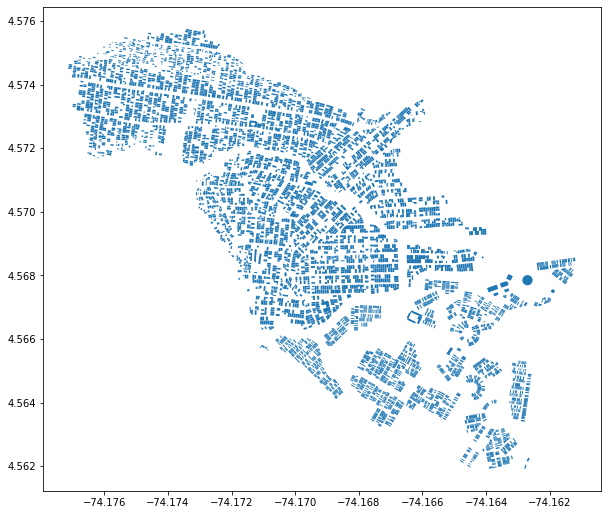

In [17]:
label_df.plot(figsize=(10,10))

In [18]:
# load geojson colombia rural test data

label_df_test = gpd.read_file(DATASET_PATH/TEST_JSON)
label_df_test = label_df_test[label_df_test['geometry'].isna() != True] # remove empty rows

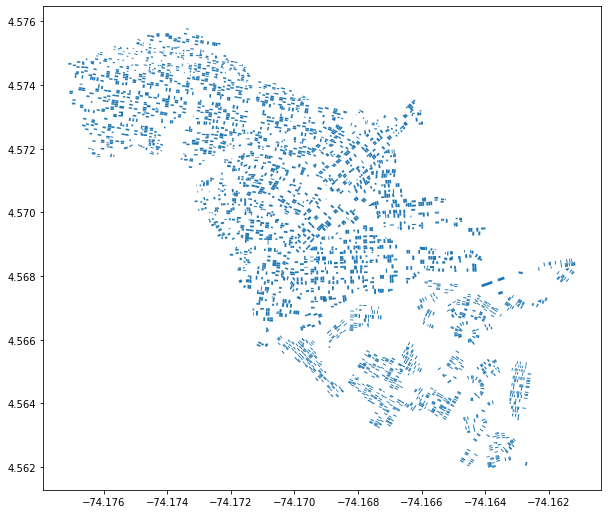

In [19]:
label_df_test.plot(figsize=(10,10))

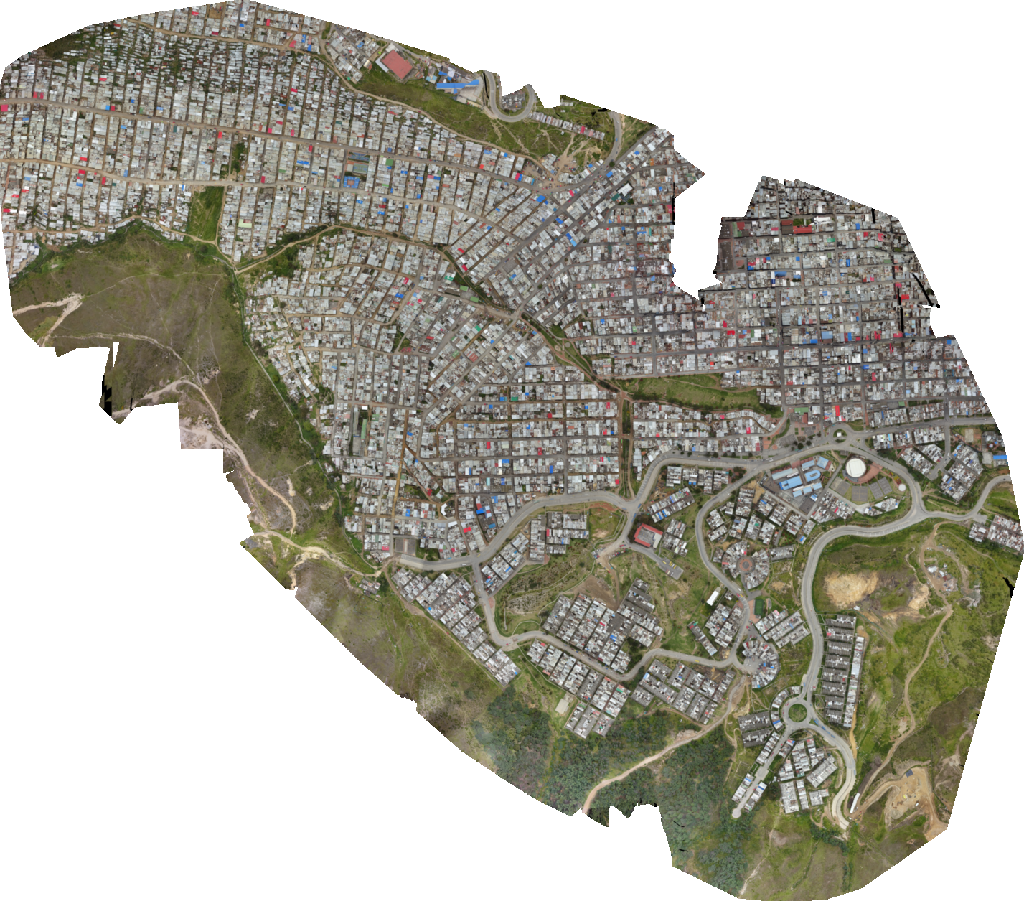

In [20]:
from PIL import Image
path = PNG_THUMBNAL
display(Image.open(path))

### Draw train and validation areas of interest (AOIs) with geojson.io

No need

## Convert train and validation AOIs to slippy map tile polygons with supermercado and geopandas

In this step, we'll use [supermercado](https://github.com/mapbox/supermercado) to generate square polygons representing all the [slippy map tiles](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames) at a specified zoom level that overlap the geojson training and validation AOIs we created above. 

For this tutorial, we'll work with slippy map tiles of `tile_size=256` and `zoom_level=19` which yields a manageable number of tiles and satisfactory segmentation results without too much preprocessing or model training time.  

You could also try setting a higher or lower `zoom_level` which would generate more or less tiles at higher or lower resolutions respectively. 

Here is an example of different tile `zoom_levels` over the same area of Zanzibar (see the round, white satellite TV dish for a consistently sized visual reference):

![zoom level comparison](https://cdn-images-1.medium.com/max/1200/1*06aV0V5_-uu0_mQCe13sBA.png)

Learn more about slippy maps [here](https://wiki.openstreetmap.org/wiki/Slippy_Map), [here](https://developers.planet.com/tutorials/slippy-maps-101/), and [here](https://wiki.openstreetmap.org/wiki/Zoom_levels). 


Then we'll merge our supermercado-generated slippy map tile polygons into one `GeoDataFrame` with [geopandas](http://geopandas.org/). We'll also check for and reconcile overlapping train and validation tiles which would otherwise throw off how we evaluate our progress with model training.

backup the id

In [21]:
trn_all = gpd.read_file(DATASET_PATH/TRAIN_JSON)

In [22]:
trn_all['original_id'] = trn_all['id']

In [23]:
trn_all.head()

,id,roof_material,verified,geometry,original_id
0,7a407f5a,healthy_metal,True,POLYGON ((-74.17071350010301 4.573169451147971...,7a407f5a
1,7a29f6b8,healthy_metal,True,POLYGON ((-74.17078792199707 4.573069486226699...,7a29f6b8
2,7a3f90f4,healthy_metal,True,"POLYGON ((-74.1708282231297 4.573195068720274,...",7a3f90f4
3,7a3fe086,healthy_metal,True,POLYGON ((-74.17058297917698 4.572976748795213...,7a3fe086
4,7a43babc,healthy_metal,True,POLYGON ((-74.17074285061349 4.573002418667922...,7a43babc


In [24]:
len(trn_all)

5995

In [25]:
#of training tiles reserve 10% for a validation set
trn_tiles, val_tiles = np.split(trn_all.sample(frac=1), [int(.9*len(trn_all))])

In [26]:
len(trn_tiles)

5395

In [27]:
len(val_tiles)

600

### supermercado-burn

Complicated step here to create X, Y, Z tiles

In [28]:
trn_tiles['dataset'] = 'trn'
val_tiles['dataset'] = 'val'

In [29]:
len(val_tiles)

600

In [30]:
trn_tiles.to_file(data_dir/f"tiles/{COUNTRY}_{TRAIN_TRN_JSON}", driver='GeoJSON')
val_tiles.to_file(data_dir/f"tiles/{COUNTRY}_{TRAIN_VAL_JSON}", driver='GeoJSON')

In [31]:
val_tiles.head()

,id,roof_material,verified,geometry,original_id,dataset
2769,7a1f5474,irregular_metal,True,POLYGON ((-74.17370164958345 4.573914475067599...,7a1f5474,val
457,7a367212,irregular_metal,True,POLYGON ((-74.17032095193721 4.571685550601696...,7a367212,val
4342,7a3995f0,irregular_metal,True,"POLYGON ((-74.16459981918815 4.56646589091615,...",7a3995f0,val
2568,7a1e70ea,irregular_metal,True,POLYGON ((-74.17216226541927 4.574580154800835...,7a1e70ea,val
3550,7a401e2a,irregular_metal,True,POLYGON ((-74.16860670779491 4.564357886132288...,7a401e2a,val


In [32]:
trn_tiles.head()

,id,roof_material,verified,geometry,original_id,dataset
1591,7a3b61f0,healthy_metal,True,"POLYGON ((-74.16611459049754 4.57038468396225,...",7a3b61f0,trn
5561,7a21f97c,irregular_metal,True,POLYGON ((-74.17696444671016 4.574589509437807...,7a21f97c,trn
5201,7a33118a,healthy_metal,True,"POLYGON ((-74.16712059712422 4.56772280249456,...",7a33118a,trn
685,7a3ff5bc,healthy_metal,True,"POLYGON ((-74.16695613615308 4.57288383626089,...",7a3ff5bc,trn
4117,7a372d4c,irregular_metal,True,POLYGON ((-74.16448751281717 4.564751028695159...,7a372d4c,trn


In [33]:
trn_out=Path(f"{data_dir}/tiles/{DATASET}_trn_aoi_z{zoom_level}_tiles.geojson")
val_out=Path(f"{data_dir}/tiles/{DATASET}_val_aoi_z{zoom_level}_tiles.geojson")
trn_out, val_out

(PosixPath('data/tiles/colombia_borde_soacha_trn_aoi_z19_tiles.geojson'),
 PosixPath('data/tiles/colombia_borde_soacha_val_aoi_z19_tiles.geojson'))

In [34]:
trn_in=f"data/tiles/{COUNTRY}_{TRAIN_TRN_JSON}"
val_in=f"data/tiles/{COUNTRY}_{TRAIN_VAL_JSON}"
trn_in, val_in

('data/tiles/colombia_train-borde_soacha_trn.geojson',
 'data/tiles/colombia_train-borde_soacha_val.geojson')

In [35]:
!pwd

/mnt/963GB/Data/Python/Code/comps/driven_data/caribbean_disaster_risk


In [36]:
!cat {trn_in} | supermercado burn {zoom_level} | mercantile shapes | fio collect > {trn_out}
#!cat {val_in} | supermercado burn {zoom_level} | mercantile shapes | fio collect > {val_out}

In [37]:
#of training tiles reserve 10% for a validation set
trn_tiles, val_tiles = np.split(trn_all.sample(frac=1), [int(.9*len(trn_all))])

In [38]:
trn_tiles_burnt = gpd.read_file(trn_out)
val_tiles_burnt = gpd.read_file(val_out)
trn_tiles_burnt['dataset'] = 'trn'
val_tiles_burnt['dataset'] = 'val'

In [39]:
trn_tiles_burnt.head()

,id,title,geometry,dataset
0,"(154121, 255472, 19)","XYZ tile (154121, 255472, 19)",POLYGON ((-74.17350769042969 4.575740479186675...,trn
1,"(154117, 255473, 19)","XYZ tile (154117, 255473, 19)",POLYGON ((-74.17625427246094 4.575056021865318...,trn
2,"(154118, 255473, 19)","XYZ tile (154118, 255473, 19)",POLYGON ((-74.17556762695312 4.575056021865318...,trn
3,"(154119, 255473, 19)","XYZ tile (154119, 255473, 19)",POLYGON ((-74.17488098144531 4.575056021865318...,trn
4,"(154120, 255473, 19)","XYZ tile (154120, 255473, 19)","POLYGON ((-74.1741943359375 4.575056021865318,...",trn


In [40]:
len(trn_tiles_burnt)

238

In [41]:
len(val_tiles_burnt)

199

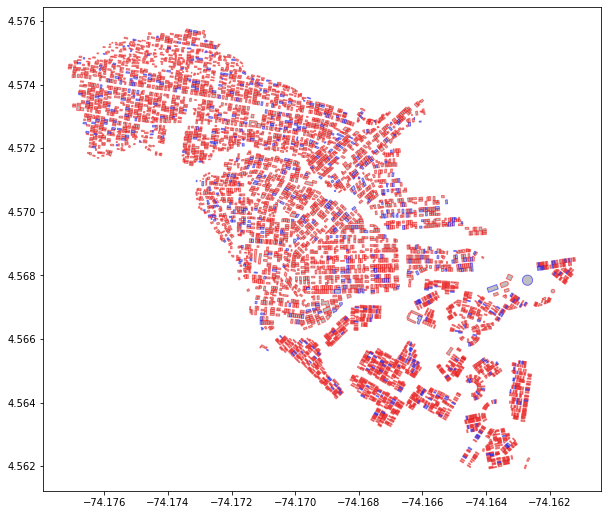

In [42]:
# see if there's overlapping tiles between trn and val
fig, ax = plt.subplots(figsize=(10,10))
trn_tiles.plot(ax=ax, color='grey', alpha=0.5, edgecolor='red')
val_tiles.plot(ax=ax, color='grey', alpha=0.5, edgecolor='blue')

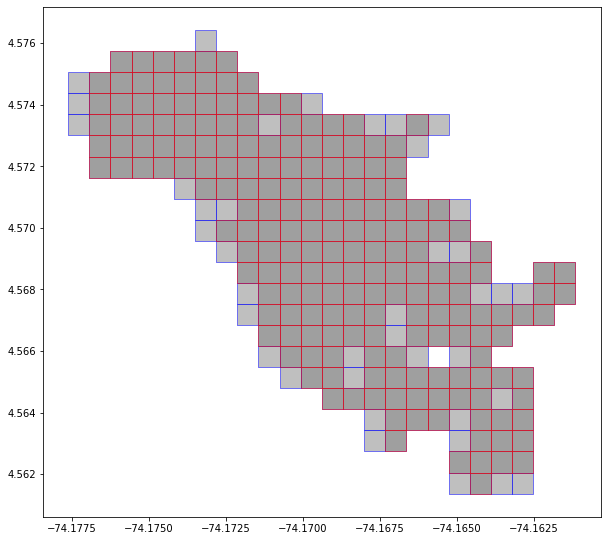

In [43]:
# see if there's overlapping tiles between trn and val
fig, ax = plt.subplots(figsize=(10,10))
trn_tiles_burnt.plot(ax=ax, color='grey', alpha=0.5, edgecolor='blue')
val_tiles_burnt.plot(ax=ax, color='grey', alpha=0.5, edgecolor='red')

In [44]:
len(trn_tiles_burnt)

238

In [45]:
len(val_tiles_burnt)

199

In [46]:
ignore_tiles, val_tiles_burnt = np.split(val_tiles_burnt.sample(frac=1), [int(.9*len(val_tiles_burnt))])

In [47]:
len(val_tiles_burnt)

20

In [48]:
# merge into one gdf to keep all trn tiles while dropping overlapping/duplicate val tiles
tiles_gdf = gpd.GeoDataFrame(pd.concat([val_tiles_burnt, trn_tiles_burnt], ignore_index=True), crs=trn_tiles_burnt.crs)

In [49]:
tiles_gdf.head()

,id,title,geometry,dataset
0,"(154131, 255486, 19)","XYZ tile (154131, 255486, 19)",POLYGON ((-74.16664123535156 4.566158017182832...,val
1,"(154116, 255475, 19)","XYZ tile (154116, 255475, 19)",POLYGON ((-74.17694091796875 4.573687105259838...,val
2,"(154126, 255480, 19)","XYZ tile (154126, 255480, 19)",POLYGON ((-74.17007446289062 4.570264802301201...,val
3,"(154128, 255482, 19)","XYZ tile (154128, 255482, 19)","POLYGON ((-74.168701171875 4.568895876541809, ...",val
4,"(154126, 255486, 19)","XYZ tile (154126, 255486, 19)",POLYGON ((-74.17007446289062 4.566158017182832...,val


In [50]:
tiles_gdf.drop_duplicates(subset=['id'], inplace=True)

In [51]:
len(tiles_gdf)

238

In [52]:
trn_tiles_burnt.crs

{'init': 'epsg:4326'}

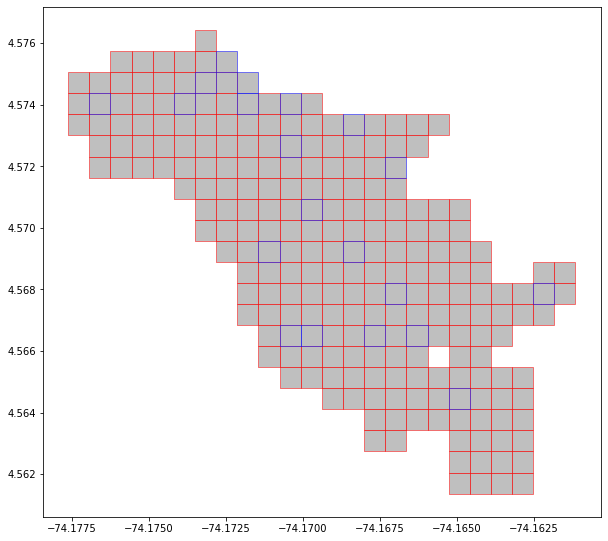

In [53]:
# check that there's no more overlapping tiles between trn and val
fig, ax = plt.subplots(figsize=(10,10))
tiles_gdf[tiles_gdf['dataset'] == 'trn'].plot(ax=ax, color='grey', edgecolor='red', alpha=0.5)
tiles_gdf[tiles_gdf['dataset'] == 'val'].plot(ax=ax, color='grey', edgecolor='blue', alpha=0.5)

In [54]:
tiles_gdf.head()

,id,title,geometry,dataset
0,"(154131, 255486, 19)","XYZ tile (154131, 255486, 19)",POLYGON ((-74.16664123535156 4.566158017182832...,val
1,"(154116, 255475, 19)","XYZ tile (154116, 255475, 19)",POLYGON ((-74.17694091796875 4.573687105259838...,val
2,"(154126, 255480, 19)","XYZ tile (154126, 255480, 19)",POLYGON ((-74.17007446289062 4.570264802301201...,val
3,"(154128, 255482, 19)","XYZ tile (154128, 255482, 19)","POLYGON ((-74.168701171875 4.568895876541809, ...",val
4,"(154126, 255486, 19)","XYZ tile (154126, 255486, 19)",POLYGON ((-74.17007446289062 4.566158017182832...,val


In [55]:
# convert 'id' string to list of ints for z,x,y
def reformat_xyz(tile_gdf):
  tile_gdf['xyz'] = tile_gdf.id.apply(lambda x: x.lstrip('(,)').rstrip('(,)').split(','))
  tile_gdf['xyz'] = [[int(q) for q in p] for p in tile_gdf['xyz']]
  return tile_gdf

In [56]:
tiles_gdf = reformat_xyz(tiles_gdf)
tiles_gdf.head()

,id,title,geometry,dataset,xyz
0,"(154131, 255486, 19)","XYZ tile (154131, 255486, 19)",POLYGON ((-74.16664123535156 4.566158017182832...,val,"[154131, 255486, 19]"
1,"(154116, 255475, 19)","XYZ tile (154116, 255475, 19)",POLYGON ((-74.17694091796875 4.573687105259838...,val,"[154116, 255475, 19]"
2,"(154126, 255480, 19)","XYZ tile (154126, 255480, 19)",POLYGON ((-74.17007446289062 4.570264802301201...,val,"[154126, 255480, 19]"
3,"(154128, 255482, 19)","XYZ tile (154128, 255482, 19)","POLYGON ((-74.168701171875 4.568895876541809, ...",val,"[154128, 255482, 19]"
4,"(154126, 255486, 19)","XYZ tile (154126, 255486, 19)",POLYGON ((-74.17007446289062 4.566158017182832...,val,"[154126, 255486, 19]"


In [57]:
len(tiles_gdf.loc[tiles_gdf['dataset'] == 'trn'])

218

In [58]:
len(tiles_gdf.loc[tiles_gdf['dataset'] == 'val'])

20

## Load slippy map tile image from COG with rio-tiler and corresponding label with geopandas

Now we'll use  [rio-tiler](https://github.com/cogeotiff/rio-tiler) and the slippy map tile polygons generated by supermercado to test load a single 256x256 pixel tile from our col_borde_rural_001 COG image file. We will also load the col_borde_rural_001 geoJSON labels into a geopandas GeoDataFrame and crop  the building geometries to only those that intersect the bounds of the tile image.

Here is a great intro to COGs, rio-tiler, and exciting developments in the cloud-native geospatial toolbox by [Vincent Sarago](https://medium.com/@_VincentS_) of [Development Seed](https://developmentseed.org/): https://medium.com/devseed/cog-talk-part-1-whats-new-941facbcd3d1

We'll then create our corresponding 3-channel RGB mask by passing these cropped geometries to solaris' df_to_px_mask function. Pixel value of 255 in the generated mask: 

- in the 1st (Red) channel represent building footprints, 
- in the 2nd (Green) channel represent building boundaries (visually looks yellow on the RGB mask display because the pixels overlap red and green+red=yellow), 
- and in the 3rd (Blue) channel represent close contact points between adjacent buildings

In [59]:
idx = 22
tiles_gdf.iloc[idx]['xyz']

[154118, 255473, 19]

In [60]:
tif_url = DATA_TIFF

tile_size default is 256

In [61]:
#inputs required for: tile(address, tile_x, tile_y, tile_z, tilesize=256, **kwargs)

In [62]:
tile, mask = rt_main.tile(tif_url, *tiles_gdf.iloc[idx]['xyz'], tilesize=tile_size)

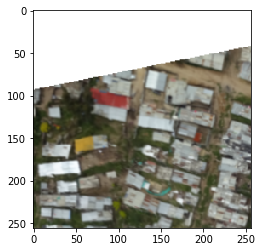

In [63]:
plt.imshow(np.moveaxis(tile,0,2))

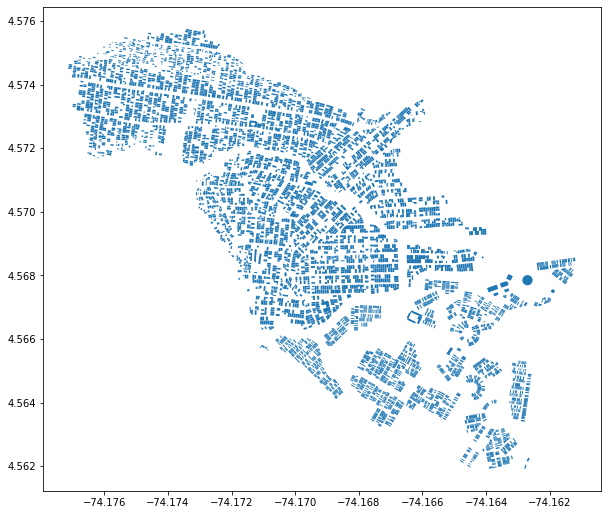

In [64]:
# redisplay our labeled geojson file
label_df.plot(figsize=(10,10))

In [65]:
# get the geometries from the geodataframe
all_polys = label_df.geometry

In [66]:
# preemptively fix and merge any invalid or overlapping geoms that would otherwise throw errors during the rasterize step. 
# TODO: probably a better way to do this

# https://gis.stackexchange.com/questions/271733/geopandas-dissolve-overlapping-polygons
# https://nbviewer.jupyter.org/gist/rutgerhofste/6e7c6569616c2550568b9ce9cb4716a3

def explode(gdf):
    """    
    Will explode the geodataframe's muti-part geometries into single 
    geometries. Each row containing a multi-part geometry will be split into
    multiple rows with single geometries, thereby increasing the vertical size
    of the geodataframe. The index of the input geodataframe is no longer
    unique and is replaced with a multi-index. 

    The output geodataframe has an index based on two columns (multi-index) 
    i.e. 'level_0' (index of input geodataframe) and 'level_1' which is a new
    zero-based index for each single part geometry per multi-part geometry
    
    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries
        
    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with each single 
                                 geometry as a separate entry in the 
                                 geodataframe. The GeoDataFrame has a multi-
                                 index set to columns level_0 and level_1
        
    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out

def cleanup_invalid_geoms(all_polys):
  all_polys_merged = gpd.GeoDataFrame()
  all_polys_merged['geometry'] = gpd.GeoSeries(cascaded_union([p.buffer(0) for p in all_polys]))

  gdf_out = explode(all_polys_merged)
  gdf_out = gdf_out.reset_index()
  gdf_out.drop(columns=['level_0','level_1'], inplace=True)
  all_polys = gdf_out['geometry']
  return all_polys

all_polys = cleanup_invalid_geoms(all_polys)

(-74.17556762695312, 4.575056021865318, -74.17488098144531, 4.575740479186675)


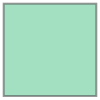

In [67]:
# get the same tile polygon as our tile image above
tile_poly = tiles_gdf.iloc[idx]['geometry']
print(tile_poly.bounds)
tile_poly

In [68]:
# get affine transformation matrix for this tile using rasterio.transform.from_bounds: https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html#rasterio.transform.from_bounds
tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
tfm

Affine(2.682209014892578e-06, 0.0, -74.17556762695312,
       0.0, -2.673661411552175e-06, 4.575740479186675)

In [69]:
DATA_TIFF

PosixPath('data/stac/colombia/borde_soacha/borde_soacha_ortho-cog.tif')

In [70]:
epsg = str(rasterio.open(DATA_TIFF).meta['crs']).split(':')[1]

In [71]:
#epsg='4326' #WGS84 no zone

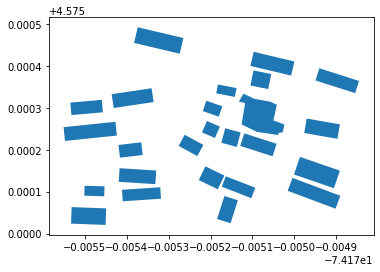

In [72]:
# crop col_borde_rural_001 geometries to what overlaps our tile polygon bounds
cropped_polys = [poly for poly in all_polys if poly.intersects(tile_poly)]
cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs={'init': f'epsg:{epsg}'})
cropped_polys_gdf.plot()

In [73]:
# burn a footprint/boundary/contact 3-channel mask with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html

fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)

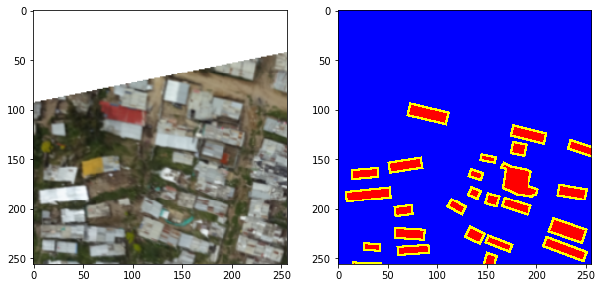

In [74]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.imshow(np.moveaxis(tile,0,2))
ax2.imshow(fbc_mask)

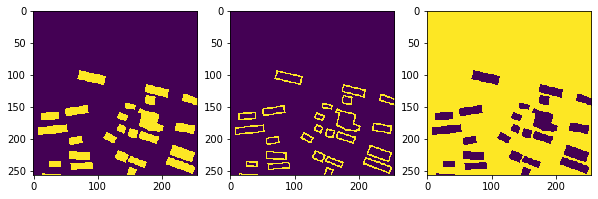

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10, 5))
ax1.imshow(fbc_mask[:,:,0])
ax2.imshow(fbc_mask[:,:,1])
ax3.imshow(fbc_mask[:,:,2])

## Make and save all the image and mask tiles

Now that we've successfully loaded one tile image from COG with rio-tiler and created its 3-channel RGB mask with solaris, let's generate our full training and validation datasets. 

We'll write some functions and loops to run through all of our `trn` and `val` tiles at `zoom_level=19` and save them as lossless `png` files in the appropriate folders with a filename schema of `{save_path}/{prefix}{z}_{x}_{y}` so we can easily identify and geolocate what tile each file represents.

In [76]:
def save_tile_img(tif_url, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  tile, mask = rt_main.tile(tif_url, x,y,z, tilesize=tile_size)
  if display: 
    plt.imshow(np.moveaxis(tile,0,2))
    plt.show()
    
  skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}.png',np.moveaxis(tile,0,2), check_contrast=False) 

In [77]:
def save_tile_mask(labels_poly, tile_poly, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
  
  cropped_polys = [poly for poly in labels_poly if poly.intersects(tile_poly)]
  cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs={'init': f'epsg:{epsg}'})
  
  fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)
  
  if display: plt.imshow(fbc_mask); plt.show()
  
  skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.png',fbc_mask, check_contrast=False) 

In [78]:
tiles_gdf[tiles_gdf['dataset'] == 'trn'].shape, tiles_gdf[tiles_gdf['dataset'] == 'val'].shape

((218, 5), (20, 5))

In [79]:
#needs to exist for code below
!cp {DATA_TIFF} tmp.tif

In [80]:
for idx, tile in tqdm(tiles_gdf.iterrows()):
    dataset = tile['dataset']
    save_tile_img('tmp.tif', tile['xyz'], tile_size, save_path=img_path, prefix=f'{DATASET}_001{dataset}_', display=False)

238it [00:33,  7.18it/s]


In [81]:
n = 40  #chunk row size
list_df = [tiles_gdf[i:i+n] for i in range(0,tiles_gdf.shape[0],n)]

In [82]:
def process_frame(df):
    for idx, tile in tqdm(tiles_gdf.iterrows()):
        dataset = tile['dataset']
        tile_poly = tile['geometry']
        save_tile_mask(all_polys, tile_poly, tile['xyz'], tile_size, save_path=mask_path,prefix=f'{DATASET}_001{dataset}_', display=False)

In [83]:
import multiprocessing as mp
pool = mp.Pool(8) # use 8 processes
funclist = []
for df in list_df:
    # process each data frame
    f = pool.apply_async(process_frame,[df])

35it [02:51,  6.60s/it]

In [84]:
# check that tile images and masks saved correctly
start_idx, end_idx = 200,205
for i,j in zip(sorted(img_path.iterdir())[start_idx:end_idx], sorted(mask_path.iterdir())[start_idx:end_idx]):
  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
  ax1.imshow(skimage.io.imread(i))
  ax2.imshow(skimage.io.imread(j))
  plt.show()

In [85]:
# compress and download
!tar -czf f'{DATASET}'_001trn.tar.gz data